# test

In [24]:
import os
from fastapi import FastAPI
from langserve import add_routes
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [25]:
from dotenv import load_dotenv
import os


load_dotenv() # Automatically finds the file named '.env'
api_key = os.getenv("GOOGLE_API_KEY")

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",  
    google_api_key=api_key, 
    temperature=.3
)


In [26]:
llm.invoke("What is the capital of egypt?")    

AIMessage(content='The capital of Egypt is **Cairo**.', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c7318-9ccd-7ca3-b765-cdf57f27f539-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 8, 'output_tokens': 8, 'total_tokens': 16, 'input_token_details': {'cache_read': 0}})

In [8]:
import time
from langchain_ollama import ChatOllama, OllamaEmbeddings

# llm = ChatOllama(model="llama3.2")
# ans=llm.invoke("Hello, Ollama!")

In [72]:
# from pprint import pprint
from functools import partial
from rich.console import Console
from rich.style import Style
from rich.theme import Theme

console = Console()
# base_qus_style = Style(color="#B90003", bold=True)
base_style = Style(color="#76B900", bold=True)
pprint = partial(console.print, style=base_style)

In [10]:
from langchain_core.runnables import RunnableLambda
from functools import partial

In [73]:
def RPrint(preface="State: "):
    def print_and_return(x, preface=""):
        print(f"{preface}{x}")
        return x
    return RunnableLambda(partial(print_and_return, preface=preface))

def PPrint(preface="State: "):
    def print_and_return(x, preface=""):
        pprint(preface, x)
        return x
    return RunnableLambda(partial(print_and_return, preface=preface))

In [12]:
from langchain_core.runnables import RunnableLambda
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from typing import List, Union
from operator import itemgetter

# zero_shot


In [11]:
# sys_msg = (
#     'chose the most relevant context to answer the question."\n'
#     'use only one word to answer the question. The answer must be one of the following: {options}]'
# )
# zsc_prompt = ChatPromptTemplate.from_messages(
#     [
#         ("system", sys_msg),
#         ('user', " the club is very good"),
#         ('assistant', "play"),
#         ("user", "{question}")
#     ])

# zsc_prompt = ChatPromptTemplate.from_template(
#     f"{sys_msg}\n\n"
#     "[[the club is very good ]][/INST]playing football</s><s>[INST]"
#     "[[{input}]]"
# )
sys_msg = (
    "Choose the most likely topic classification given the sentence as context."
    "from the  sentence, choose the most relevtant topic from the following options: {options}]"
    " Only one word, no explanation.\n[Options : {options}]"
)
zsc_prompt = ChatPromptTemplate.from_messages([
    ("system", sys_msg),
    ("user", "[[The sea is awesome]]"),
    ("assistant", " the sea is the key so it is  boat"),
    ('ai', 'boat'),
    ("user", "[[{input}]]"),

])

# zsc_prompt = ChatPromptTemplate.from_template(
#     f"{sys_msg}\n\n"
#     "[[The sea is awesome]][/INST]boat</s><s>[INST]"
#     "[[{input}]]"
# )
# llm = ChatGoogleGenerativeAI(
#     model="gemini-2.5-flash-lite",  
#     google_api_key=api_key, 
#     temperature=.3
# )
# llm = ChatOllama(model="llama3.2", temperature=0.0)
instr = llm | StrOutputParser()

In [13]:
zero_shot=zsc_prompt | instr
# zero_shot.invoke({'input':"I get seasick, so I think I'll pass on the trip'", 'options':["car", "boat", "airplane", "bike"]})
zero_shot.invoke({'input':"I'm scared of heights, so flying probably isn't for me", 'options':["car", "boat", "airplane", "bike"]})

'airplane'

In [14]:

## Function that just prints out the first word of the output. With early stopping bind
def zsc_call(input, options=["car", "boat", "airplane", "bike"]):
    return zero_shot.invoke({"input" : input, "options" : options}).split()[0]

print("-" * 80)
print(zsc_call("Should I take the next exit, or keep going to the next one?"))

print("-" * 80)
print(zsc_call("I get seasick, so I think I'll pass on the trip"))

print("-" * 80)
print(zsc_call("I'm scared of heights, so flying probably isn't for me"))
print("-" * 80)
print(zsc_call(" i like to practice  with it"))

--------------------------------------------------------------------------------
car
--------------------------------------------------------------------------------
boat
--------------------------------------------------------------------------------
airplane
--------------------------------------------------------------------------------
boat


In [209]:
# %%time
## ^^ This notebook is timed, which will print out how long it all took
gen_prompt = ChatPromptTemplate.from_template(
    "Make a new sentence about the the following topic: {topic}. Be creative!"
)

gen_chain = gen_prompt | llm | StrOutputParser()

input_msg = "bike" 
options = ["car", "boat", "airplane", "bike"]

chain = (
    ## -> 
    # {"input", options},
    {'topic' : zero_shot}
    |PPrint()
    ## -> {**, "topic"}
    | gen_chain
    # | print()
    ## -> string
)

chain.invoke({"input" : input_msg, "options" : options})

State: 
{'topic': 'bike'}

'The chrome steed, a silent whisper of freedom, carried me on wings of wind, painting streaks of exhilaration across the asphalt canvas.'

# RunnableAssign

In [13]:
%%time
## ^^ This notebook is timed, which will print out how long it all took
from langchain_core.runnables import RunnableBranch, RunnablePassthrough
from langchain_core.runnables.passthrough import RunnableAssign
from functools import partial
instruct_llm= llm | StrOutputParser()

CPU times: total: 0 ns
Wall time: 3.38 ms


In [14]:
big_chain = (
    PPrint()
    ## Manual mapping. Can be useful sometimes and inside branch chains
    | {'input' : lambda d: d.get('input'), 'topic' : zero_shot}
    | PPrint()
    ## RunnableAssign passing. Better for running state chains by default
    | RunnableAssign({'generation' : gen_chain})
    | PPrint()
    ## Using the input and generation together
    | RunnableAssign({'combination' : (
        ChatPromptTemplate.from_template(
            "Consider the following passages:"
            "\nP1: {input}"
            "\nP2: {generation}"
            "\n\nCombine the ideas from both sentences into one simple one."
        )
        | instruct_llm
    )})
)

output = big_chain.invoke({
    "input" : "I'm scared of heights, so flying probably isn't for me",
    "options" : ["car", "boat", "airplane", "bike", "unknown"]
})
pprint("Final Output: ", output)

State: 
{
    'input': "I'm scared of heights, so flying probably isn't for me",
    'options': ['car', 'boat', 'airplane', 'bike', 'unknown']
}

State: 
{'input': "I'm scared of heights, so flying probably isn't for me", 'topic': 'airplane'}

State: 
{
    'input': "I'm scared of heights, so flying probably isn't for me",
    'topic': 'airplane',
    'generation': 'As the sun set over the horizon, a lone seagull soared alongside an old biplane, its propellers 
whirring in perfect harmony with the rhythmic crash of the waves against the shore.'
}

Final Output: 
{
    'input': "I'm scared of heights, so flying probably isn't for me",
    'topic': 'airplane',
    'generation': 'As the sun set over the horizon, a lone seagull soared alongside an old biplane, its propellers 
whirring in perfect harmony with the rhythmic crash of the waves against the shore.',
    'combination': "Here's a combined sentence:\n\nAs I stood on the edge of the cliff, watching the sun set over 
the horizon, a lone seagull soared alongside an old biplane that had landed nearby, its propellers whirring in 
perfect harmony with the rhythmic crash of the waves against the shore."
}

> <img src="https://dli-lms.s3.amazonaws.com/assets/s-fx-15-v1/imgs/running_state_chain.png" width=1000px/>
<!-- > <img src="https://drive.google.com/uc?export=view&id=1Oo7AauYGj4dxepNReRG2JezmvQLyqXsN" width=1000px/> -->

# Knowledge Base 

In [60]:
from pydantic import BaseModel, Field
from typing import Any, Dict, Union, Optional

class KnowledgeBase(BaseModel):
    ## Fields of the BaseModel, which will be validated/assigned when the knowledge base is constructed
    topic: str = Field('general', description="Current conversation topic")
    user_preferences: Dict[str, Union[str, Any]] = Field({}, description="User preferences and choices")
    session_notes: list = Field([], description="Notes on the ongoing session")
    unresolved_queries: list = Field([], description="Unresolved user queries")
    action_items: list = Field([], description="Actionable items identified during the conversation")
# instruct_chat = instruct_chat.with_structured_output(KnowledgeBase)
print(repr(KnowledgeBase(topic = "Travel")))

KnowledgeBase(topic='Travel', user_preferences={}, session_notes=[], unresolved_queries=[], action_items=[])


In [61]:
from langchain_core.output_parsers import PydanticOutputParser

instruct_string = PydanticOutputParser(pydantic_object=KnowledgeBase).get_format_instructions()
pprint(instruct_string)

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": 
"array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": 
["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"topic": {"default": "general", "description": "Current conversation topic", "title": "Topic", 
"type": "string"}, "user_preferences": {"additionalProperties": {"anyOf": [{"type": "string"}, {}]}, "default": {},
"description": "User preferences and choices", "title": "User Preferences", "type": "object"}, "session_notes": 
{"default": [], "description": "Notes on the ongoing session", "items": {}, "title": "Session Notes", "type": 
"array"}, "unresolved_queries": {"default": [], "description": "Unresolved user queries", "items": {}, "title": 
"Unresolved Queries", "type": "array"}, "action_items": {"default": [], "description": "Actionable items identified
during the conversation", "items": {}, "title": "Action Items", "type": "array"}}}
```

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",  
    google_api_key=api_key, 
    temperature=.3
)
# llm = ChatOllama(model="llama3.2",temperature=.5)

In [129]:
llm.invoke('hi')

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c684d-43b9-7022-8396-603c9756e067-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 2, 'output_tokens': 132, 'total_tokens': 134, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 122}})

In [116]:
from langchain_core.runnables import RunnableLambda, RunnableAssign
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import List, Dict, Any
import re
import json
import ast  # <--- NEW IMPORT for fixing single quotes

# --- 1. YOUR SCHEMA (Keep this) ---
class KnowledgeBase(BaseModel):
    topic: str = Field('general', description="Current conversation topic")
    user_preferences: Dict[str, Any] = Field({}, description="User preferences")
    session_notes: List[str] = Field([], description="Notes on session")
    unresolved_queries: List[str] = Field([], description="Unresolved queries")
    action_items: List[str] = Field([], description="Actionable items")

# --- 2. THE ROBUST EXTRACTOR ---
def RExtract(pydantic_class, llm, prompt):
    parser = PydanticOutputParser(pydantic_object=pydantic_class)

    # HELPER 1: Get text safely from Gemini/Llama
    def get_content_safe(msg):
        content = msg.content if hasattr(msg, 'content') else msg
        if isinstance(content, list): return " ".join([str(x) for x in content])
        return str(content)

    # HELPER 2: The "Magical" Cleaner
    def clean_and_parse(text):
        # 1. Clean Markdown
        text = text.replace("```json", "").replace("```", "").strip()
        
        # 2. Extract content between first { and last }
        match = re.search(r'\{.*\}', text, re.DOTALL)
        if match: text = match.group()

        # 3. TRY STRICT JSON (The standard way)
        try:
            return parser.parse(text)
        except Exception:
            pass # Failed? Move to fallback.

        # 4. FALLBACK: Handle Single Quotes (Python Dict format)
        try:
            # ast.literal_eval safely evaluates a string containing a Python dict
            py_dict = ast.literal_eval(text)
            return pydantic_class(**py_dict)
        except Exception as e:
            # If both fail, return empty or raise error
            raise ValueError(f"Failed to parse. Text was: {text[:50]}... Error: {e}")

    # THE CHAIN
    instruct_merge = RunnableAssign({'format_instructions': lambda x: parser.get_format_instructions()})
    
    return (
        instruct_merge 
        | prompt 
        | llm 
        | RunnableLambda(get_content_safe) 
        | RunnableLambda(clean_and_parse) # <--- Uses the new robust cleaner
    )

In [130]:
# 1. Setup LLM (Ensure you are using the LangChain wrapper)
# from langchain_google_genai import ChatGoogleGenerativeAI
# llm = ChatGoogleGenerativeAI(
#     model="gemini-2.0-flash",
#     google_api_key="PASTE_YOUR_NEW_KEY_HERE",
#     temperature=0
# )


# --- UPDATED PROMPT (Force Attention) ---
prompt = ChatPromptTemplate.from_template(
    """
    You are an expert Data Extraction AI. 
    Your job is to extract SPECIFIC details from the user's input.
    
    RULES:
    1. If the user mentions a problem (like "car engine"), the 'topic' MUST be specific (e.g., "mechanic", not "general").
    2. If the user asks for help, add it to 'action_items'.
    3. Do NOT return empty lists if there is data in the text.

    --- YOUR TASK ---
    Extract the following user input into JSON.
    {format_instructions}
    
    User Input: {text}
    """
)
# parser_prompt = ChatPromptTemplate.from_template(
#     "Update the knowledge base: {format_instructions}. Only use information from the input."
#     "\n\nNEW MESSAGE: ('text')"
# )

# 3. Run
print("--- 🧠 Testing Gemini Fix ---")
kb_extractor = RExtract(KnowledgeBase, llm, prompt)

knowledge = kb_extractor.invoke({"text" : "iam mark , i wnat some help i have a proplem in my car engine"})
pprint(knowledge)
# try:
#     result = kb_extractor.invoke({"text": user_input})
#     print(f"✅ Topic: {result.topic}")
#     print(f"✅ Actions: {result.action_items}")
#     print("\nFull Object:\n", result)
# except Exception as e:
#     print(f"❌ Error: {e}")

--- 🧠 Testing Gemini Fix ---


KnowledgeBase(
    topic='mechanic',
    user_preferences={'name': 'mark'},
    session_notes=[],
    unresolved_queries=['problem in my car engine'],
    action_items=['provide help']
)

# chat bot 


In [131]:
class KnowledgeBase(BaseModel):
    firstname: str = Field('unknown', description="Chatting user's first name, unknown if unknown")
    lastname: str = Field('unknown', description="Chatting user's last name, unknown if unknown")
    location: str = Field('unknown', description="Where the user is located")
    summary: str = Field('unknown', description="Running summary of conversation. Update this with new input")
    response: str = Field('unknown', description="An ideal response to the user based on their new message")


parser_prompt = ChatPromptTemplate.from_template(
    "You are chatting with a user. The user just responded ('input'). Please update the knowledge base."
    " Record your response in the 'response' tag to continue the conversation."
    " Do not hallucinate any details, and make sure the knowledge base is not redundant."
    " Update the entries frequently to adapt to the conversation flow."
    "\n{format_instructions}"
    "\n\nOLD KNOWLEDGE BASE: {know_base}"
    "\n\nNEW MESSAGE: {input}"
    "\n\nNEW KNOWLEDGE BASE:"
)

In [132]:
extractor = RExtract(KnowledgeBase, llm, parser_prompt)
info_update = RunnableAssign({'know_base' : extractor})

## Initialize the knowledge base and see what you get
state = {'know_base' : KnowledgeBase()}
state['input'] = "My name is Carmen Sandiego! Guess where I am! Hint: It's somewhere in the United States."
state = info_update.invoke(state)
pprint(state)

{
    'know_base': KnowledgeBase(
        firstname='Carmen',
        lastname='Sandiego',
        location='United States',
        summary="The user's name is Carmen Sandiego, and they are asking me to guess their location, which is 
somewhere in the United States.",
        response="It's great to meet you, Carmen Sandiego! That's a fun challenge! I'll need a few more hints to 
narrow down your location within the United States. Where should I start looking?"
    ),
    'input': "My name is Carmen Sandiego! Guess where I am! Hint: It's somewhere in the United States."
}

In [133]:
state['input'] = "I'm in a place considered the birthplace of Jazz."
state = info_update.invoke(state)
pprint(state)

{
    'know_base': KnowledgeBase(
        firstname='Carmen',
        lastname='Sandiego',
        location='New Orleans, Louisiana, United States',
        summary="The user's name is Carmen Sandiego, and they are asking me to guess their location, which is 
somewhere in the United States. They have provided a hint that they are in the birthplace of Jazz.",
        response='This is a great hint! The birthplace of Jazz immediately makes me think of New Orleans, 
Louisiana. Am I getting warm, Carmen?'
    ),
    'input': "I'm in a place considered the birthplace of Jazz."
}

In [134]:
state['input'] = "Yeah, I'm in New Orleans... How did you know?"
state = info_update.invoke(state)
pprint(state)

{
    'know_base': KnowledgeBase(
        firstname='Carmen',
        lastname='Sandiego',
        location='New Orleans, Louisiana, United States',
        summary="The user's name is Carmen Sandiego, and I successfully guessed their location as New Orleans, 
Louisiana, based on their hint about being in the birthplace of Jazz. They confirmed the location.",
        response="Excellent! I knew it! The 'birthplace of Jazz' is a very strong clue for New Orleans. It's a city
with such a unique and vibrant culture. What brings you to New Orleans, Carmen?"
    ),
    'input': "Yeah, I'm in New Orleans... How did you know?"
}

# docoment 

In [42]:
# from langchain_community.document_loaders import ArxivLoader

# ## Loading in the file

# ## More specialized loader, won't work for everything, but simple API and usually better results
# # documents = ArxivLoader(query="2404.16130").load()  ## GraphRAG
# documents = ArxivLoader(query="2404.03622").load()  ## Visualization-of-Thought
# # documents = ArxivLoader(query="2404.19756").load()  ## KAN: Kolmogorov-Arnold Networks
# # documents = ArxivLoader(query="2404.07143").load()  ## Infini-Attention
# # documents = ArxivLoader(query="2210.03629").load()  ## ReAct

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv() # Automatically finds the file named '.env'
api_key = os.getenv("GOOGLE_API_KEY")



In [15]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",  
    google_api_key=api_key, 
    temperature=.3
)
# llm = ChatOllama(model="llama3.2",temperature=0.0)
instruct_llm= llm | StrOutputParser()

In [16]:
instruct_llm.invoke('hi')

'Hi there! How can I help you today?'

In [17]:
from langchain_community.document_loaders import PyPDFLoader

print("--- 📂 Loading PDF (PyPDF) ---")

# 1. Define your exact filename
filename = "ai_unexpected.pdf"
# 2. Load the PDF
loader = PyPDFLoader(filename)
docs = loader.load()
    
# 3. Print the first 500 characters to verify
print("\n--- Page 1 Content ---")
print(docs[0].page_content[:1000])


--- 📂 Loading PDF (PyPDF) ---

--- Page 1 Content ---
Introduction* 1.1  
Introduction Rapid advances in artificial intelligence (AI) over the past decade have been 
accompanied by several high-profile failures [1], highlighting the importance of ensuring 
that intelligent machines are beneficial to humanity. This realiza tion has given rise to the 
new subfield of research known as AI Safety and Security [2], which encompasses a wide 
range of research areas and has seen steady growth in publications in recent years [3–10]. 
However, the underlying assumption in this research is that the problem of controlling 
highly capable intelligent machines is solvable, though no rig orous mathematical proof or 
argumentation has been presented to demon strate that the AI control problem is solvable 
in principle, let alone in practice. In computer science, it is standard practice to first 
determine whether a prob lem belongs to a class of unsolvable problems before investing 
resources in tryi

In [166]:
docs[1].page_content[:1000]

'security in AI. However, concepts such as safety and security are notoriously dif f icult to \ntest or measure accurately, even for non-AI software, despite years of research [13]. At \nbest, we can probably distinguish between perfectly safe and as safe as an average person \nperforming a similar task. However, society is unlikely to tolerate machine errors, even if \nthey occur with a frequency typical of human performance or even less frequently. We \nexpect machines to perform better and will not accept partial safety when dealing with \nsuch highly capable systems. The impact of AI (both positive and negative [3]) is strongly \nrelated to its capability. With respect to possible existential impacts, there is no such thing \nas partial safety. An initial understanding of the control problem may suggest designing a \nmachine that accurately follows human commands. However, because of pos sible \nconflicting or paradoxical commands, ambiguity of human languages [14], and perverse \n

In [167]:
docs[1].metadata

{'producer': 'Microsoft® Word for Microsoft 365',
 'creator': 'Microsoft® Word for Microsoft 365',
 'creationdate': '2026-02-17T00:51:03+02:00',
 'author': 'Mark Maged Sdky',
 'moddate': '2026-02-17T00:51:03+02:00',
 'source': 'ai_unexpected.pdf',
 'total_pages': 9,
 'page': 1,
 'page_label': '2'}

In [18]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1200,
    chunk_overlap=100,
    separators=["\n\n", "\n", ".", ";", ",", " ", ""],
)
docs_split = text_splitter.split_documents(docs)
print(len(docs_split))

34


In [169]:
print(docs_split[1].page_content[:500])

defined, and poorly researched. A computer science problem could be solvable, 
unsolvable, undecidable, or partially solvable; we don’t know the actual status of the AI 
control problem. It is possible that some forms of con trol may be possible in certain 
situations, but it is also possible that partial control may be insufficient in many cases. 
Without a better understanding of the nature and feasibility of the AI control problem, it is 
difficult to deter mine an appropriate course of actio


In [170]:
for i in (0, 1,5,-1):
    pprint(f"[Document {i}]")
    print(docs_split[i].page_content)
    pprint("="*64)

[Document 0]

Introduction* 1.1  
Introduction Rapid advances in artificial intelligence (AI) over the past decade have been 
accompanied by several high-profile failures [1], highlighting the importance of ensuring 
that intelligent machines are beneficial to humanity. This realiza tion has given rise to the 
new subfield of research known as AI Safety and Security [2], which encompasses a wide 
range of research areas and has seen steady growth in publications in recent years [3–10]. 
However, the underlying assumption in this research is that the problem of controlling 
highly capable intelligent machines is solvable, though no rig orous mathematical proof or 
argumentation has been presented to demon strate that the AI control problem is solvable 
in principle, let alone in practice. In computer science, it is standard practice to first 
determine whether a prob lem belongs to a class of unsolvable problems before investing 
resources in trying to solve it. Despite the recognition that the probl

================================================================

[Document 1]

defined, and poorly researched. A computer science problem could be solvable, 
unsolvable, undecidable, or partially solvable; we don’t know the actual status of the AI 
control problem. It is possible that some forms of con trol may be possible in certain 
situations, but it is also possible that partial control may be insufficient in many cases. 
Without a better understanding of the nature and feasibility of the AI control problem, it is 
difficult to deter mine an appropriate course of action [11]. Potential control 
methodologies for artificial general intelligence (AGI) have been broadly classified into two 
categories: Methods based on capa bility control and motivational control [12]. Capability 
control methods aim to limit the damage that AGI systems can cause by placing them in 
constrained environments, adding shutdown mechanisms or trip wires. Motivational 
control methods attempt to design AGI systems to have an innate desire not to cause 
harm, even in the absence of cap

================================================================

[Document 5]

high-risk, negative-reward situation. No wonder many consider this to be the most 
important problem humanity has ever faced. The outcome could be prosperity or 
extinction, and the fate of the universe hangs in the balance. A proof of the solvability or 
non-solvability of the AI control problem would be the most important proof ever. 1.3 
Obstacles to Controlling AI Controlling an AGI is likely to require a toolbox with certain 
capabilities, such as explainability, predictability, and model verifiability [15]. However, it is 
likely that many of the desired tools are not available to us. • The concept of 
Unexplainability in AI refers to the impossibility of providing an explanation for certain 
decisions made by an intelligent system that is 100% accurate and understandable. A 
complementary concept to Unexplainability, Incomprehensibility of AI addresses the 
inability of people to fully understand an explanation provided by an AI. We define 
Incomprehensibility as the impossibili

================================================================

[Document -1]

Agent, Roman V . Yampolskiy, Journal of Artificial Intelligence and Consciousness, Vol 7, 
Issue No 1., Copyright © 2020 by World Scientific.


================================================================

In [32]:
import os
from fastapi import FastAPI
from langserve import add_routes
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [190]:
class DocumentSummaryBase(BaseModel):
    running_summary: str = Field("", description="Running description of the document. Do not override; only update!(3 sentance)")
    main_ideas: List[str] = Field([], description="Most important information from the document (max 3)")
    loose_ends: List[str] = Field([], description="Open questions that would be good to incorporate into summary, but that are yet unknown (max 3)")


summary_prompt = ChatPromptTemplate.from_template(
    "You are generating a running summary of the document. make it \n"
    "make the {{running_summary}} about 4 sentences long, and make sure to include the main ideas and any loose ends or open questions that arise from the document. Do not remove any information from the summary, only add to it as you read more of the document. If there are no new main ideas or loose ends, just update the running summary with new information from the document."
    "Make it readable by a technical user."
    " After this, the old knowledge base will be replaced by the new one. Make sure a reader can still understand everything."
    " Keep it short, but as dense and useful as possible! The information should flow from chunk to (loose ends or main ideas) to running_summary."
    " The updated knowledge base keep all of the information from running_summary here: {info_base}."
    "\n\n{format_instructions}. Follow the format precisely, including quotations and commas"
    "\n\nWithout losing any of the info, update the knowledge base with the following: {input}"
)

In [187]:
def RExtract(pydantic_class, llm, prompt):
    '''
    Runnable Extraction module
    Returns a knowledge dictionary populated by slot-filling extraction
    '''
    parser = PydanticOutputParser(pydantic_object=pydantic_class)
    instruct_merge = RunnableAssign({'format_instructions' : lambda x: parser.get_format_instructions()})
    def preparse(string):
        if '{' not in string: string = '{' + string
        if '}' not in string: string = string + '}'
        string = (string
            .replace("\\_", "_")
            .replace("\n", " ")
            .replace("\]", "]")
            .replace("\[", "[")
        )
        # print(string)  ## Good for diagnostics
        return string
    return instruct_merge | prompt | llm | preparse | parser


In [184]:
latest_summary = ""

## TODO: Use the techniques from the previous notebook to complete the exercise
def RSummarizer(knowledge, llm, prompt, verbose=False):
    '''
    Exercise: Create a chain that summarizes
    '''
 

    def summarize_docs(docs):        
        
        parse_chain = RunnableAssign({'info_base' : RExtract(knowledge.__class__, llm, prompt)})
        state = {'info_base' : knowledge}

        global latest_summary  ## If your loop crashes, you can check out the latest_summary
        
        for i, doc in enumerate(docs):
            state['input'] = doc.page_content
            state = parse_chain.invoke(state)

            assert 'info_base' in state 
            if verbose:
                print(f"Considered {i+1} documents")
                pprint(state['info_base'])
                latest_summary = state['info_base']
                # clear_output(wait=True)

        return state['info_base']
    return RunnableLambda(summarize_docs)


In [191]:
#  instruct_model = ChatNVIDIA(model="mistralai/mixtral-8x7b-instruct-v0.1").bind(max_tokens=4096)
# instruct_model = ChatNVIDIA(model="mistralai/mixtral-8x22b-instruct-v0.1").bind(max_tokens=4096)
instruct_llm = llm | StrOutputParser()

## Take the first 10 document chunks and accumulate a DocumentSummaryBase
summarizer = RSummarizer(DocumentSummaryBase(), instruct_llm, summary_prompt, verbose=True)
summary = summarizer.invoke(docs_split[:3])

Considered 1 documents


DocumentSummaryBase(
    running_summary='Rapid advances in AI have led to the emergence of AI Safety and Security, a field focused on 
ensuring beneficial intelligent machines following high-profile failures. A critical, yet unproven, assumption 
within this research is the solvability of the AI control problem. Unlike standard computer science practice, there
is no rigorous mathematical proof demonstrating that AI control is solvable in principle. Consequently, despite its
recognized importance, the AI control problem remains poorly understood, defined, and researched.',
    main_ideas=[
        'AI Safety and Security is an emerging field driven by AI failures and the need to ensure beneficial 
intelligent machines.',
        'A fundamental, unproven assumption in AI Safety research is that the problem of controlling highly capable
AI is solvable.',
        'The AI control problem, despite its critical importance, is currently poorly understood, defined, and 
researched, lacking rigorous mathematical proof of its solvability in principle.'
    ],
    loose_ends=[
        'Is the AI control problem fundamentally solvable in principle, or does it belong to a class of unsolvable 
problems?',
        'What specific aspects contribute to the AI control problem being poorly understood, defined, and 
researched?'
    ]
)

Considered 2 documents


DocumentSummaryBase(
    running_summary='Rapid advances in AI have led to the emergence of AI Safety and Security, a field focused on 
ensuring beneficial intelligent machines following high-profile failures. A critical, yet unproven, assumption 
within this research is the solvability of the AI control problem, which, unlike standard computer science, lacks 
rigorous mathematical proof of its solvability in principle and remains poorly understood, defined, and researched.
The fundamental status of this problem (solvable, unsolvable, undecidable, or partially solvable) is unknown, 
making it difficult to determine appropriate actions, especially as partial control may be insufficient. Potential 
AGI control methodologies are broadly categorized into capability control, which limits damage via constrained 
environments or shutdown mechanisms, and motivational control, which aims to instill an innate desire not to cause 
harm.',
    main_ideas=[
        'AI Safety and Security is an emerging field driven by AI failures, focused on ensuring beneficial 
intelligent machines, but it relies on the unproven assumption that the AI control problem is solvable.',
        "The AI control problem's fundamental status (solvable, unsolvable, undecidable, or partially solvable) is 
unknown, hindering the determination of appropriate control strategies, and even partial control may prove 
insufficient.",
        'Potential AGI control methodologies are broadly classified into capability control (e.g., constrained 
environments, shutdowns) and motivational control (e.g., designing for innate harmlessness).'
    ],
    loose_ends=[
        'Given the unknown fundamental status of the AI control problem, what are the implications for the 
long-term viability and effectiveness of current AI Safety research directions?',
        'What specific challenges exist in rigorously defining and researching the AI control problem, especially 
considering the potential for partial control to be insufficient?'
    ]
)

Considered 3 documents


DocumentSummaryBase(
    running_summary="AI Safety and Security emerged from AI failures, focusing on ensuring beneficial intelligent 
machines, but it hinges on the unproven solvability of the AI control problem, which is defined as humanity safely 
controlling superior intelligence. This problem's fundamental status (solvable, unsolvable, undecidable, or 
partially solvable) is unknown, complicating the determination of effective strategies, especially since partial 
control may be insufficient. While control methodologies include temporary capability controls and motivational 
controls, the latter, aiming to instill innate harmlessness, should be integrated during design and training. Value
alignment is currently the most studied approach to achieve this control, a field further explored in works by 
Roman Yampolskiy.",
    main_ideas=[
        'AI Safety and Security is an emerging field driven by AI failures, focused on ensuring beneficial 
intelligent machines, but it relies on the unproven assumption that the AI control problem, defined as humanity 
safely controlling superior intelligence, is solvable.',
        "The AI control problem's fundamental status (solvable, unsolvable, undecidable, or partially solvable) is 
unknown, hindering the determination of appropriate control strategies, and even partial control may prove 
insufficient.",
        'While potential AGI control methodologies include temporary capability controls and motivational controls,
the latter, including the most studied approach of value alignment, must be integrated during the design and 
training phase.'
    ],
    loose_ends=[
        'Given the unknown fundamental status of the AI control problem, what are the implications for the 
long-term viability and effectiveness of current AI Safety research directions?',
        'What specific challenges exist in rigorously researching the AI control problem, especially considering 
the potential for partial control to be insufficient, and how does the provided definition aid this research?',
        'What specific mechanisms or techniques within "value alignment" are being studied, and how do they address
the challenges of integrating motivational control at the design and training phase?'
    ]
)

In [192]:
pprint(latest_summary)

DocumentSummaryBase(
    running_summary="AI Safety and Security emerged from AI failures, focusing on ensuring beneficial intelligent 
machines, but it hinges on the unproven solvability of the AI control problem, which is defined as humanity safely 
controlling superior intelligence. This problem's fundamental status (solvable, unsolvable, undecidable, or 
partially solvable) is unknown, complicating the determination of effective strategies, especially since partial 
control may be insufficient. While control methodologies include temporary capability controls and motivational 
controls, the latter, aiming to instill innate harmlessness, should be integrated during design and training. Value
alignment is currently the most studied approach to achieve this control, a field further explored in works by 
Roman Yampolskiy.",
    main_ideas=[
        'AI Safety and Security is an emerging field driven by AI failures, focused on ensuring beneficial 
intelligent machines, but it relies on the unproven assumption that the AI control problem, defined as humanity 
safely controlling superior intelligence, is solvable.',
        "The AI control problem's fundamental status (solvable, unsolvable, undecidable, or partially solvable) is 
unknown, hindering the determination of appropriate control strategies, and even partial control may prove 
insufficient.",
        'While potential AGI control methodologies include temporary capability controls and motivational controls,
the latter, including the most studied approach of value alignment, must be integrated during the design and 
training phase.'
    ],
    loose_ends=[
        'Given the unknown fundamental status of the AI control problem, what are the implications for the 
long-term viability and effectiveness of current AI Safety research directions?',
        'What specific challenges exist in rigorously researching the AI control problem, especially considering 
the potential for partial control to be insufficient, and how does the provided definition aid this research?',
        'What specific mechanisms or techniques within "value alignment" are being studied, and how do they address
the challenges of integrating motivational control at the design and training phase?'
    ]
)

# Embedding Models

----

<br>

## **Part 1:** Refreshing On Embedding Models

In this section, we'll review the ideas surrounding natural language processing with deep learning to define what embedding models are and how they're related to the tools we've taken for granted thus far.

<br>

### **Understanding Latent Embeddings**

Latent embeddings represent the middle ground in deep learning networks, bridging the gap between input and output. For instance, let's consider a lightweight two-layer network designed to classify [**MNIST digits**](https://en.wikipedia.org/wiki/MNIST_database). For this, the inputs and outputs might be flattened images and one-hot probability vectors, respectively. Then, the values produced by the first layer in this setup are the latent embeddings of the image which, by optimization, converge into useful representations for the final layer to use. This makes them **semantically rich embeddings** that may not be human-interpretable but can still be leveraged for their raw vector properties.

<br>

### **Word Embeddings: The Building Blocks of Language Models**

Word embeddings are high-dimensional vector representations of individual words, forming the backbone of deep language models. These embeddings are created through an optimization process within an end-to-end pipeline tailored for specific tasks. [**Word2vec**](https://en.wikipedia.org/wiki/Word2vec) is a prominent standalone example for those interested. In practical terms, a token from a language model's $v$-token vocabulary gets mapped from a token index to an $d$-dimensional token embedding:

$$\text{Token Index} \in \{0, 1, \cdots, v-1\} \to \text{Token Embedding} \in \mathbb{R}^{d}$$

For a sequence of $n$ tokens, this mapping extends to the entire sequence:

$$\text{Token Sequence} \in \{0, 1, \cdots, v-1\}^{v} \to \text{Embedding Sequence} \in \mathbb{R}^{n\times d}$$

<br>

### **Sentence/Document Embeddings: Capturing Context and Meaning**

When dealing with sentences or entire documents, embeddings play a crucial role in capturing context, meanings, and interactions between elements. Practically all large language models leverage a **transformer-like architecture** to generate these sentence/document embeddings. The transformer allows the network to communicate both per-token-level and sequence-level information as it becomes useful for the optimization problem.

<br>

### **Decoder Models in Language Generation**

Decoder models, commonly used in chatbots and other language generation tasks, start by taking a sequence of tokens as input. They embed these tokens into a latent sequence, applying unidirectional reasoning to focus on a specific part of the output sequence. From this focused, semantically dense point, the model predicts the next token in the sequence:

$$$$
$$\text{[ Next-Token Generation ]}$$
$$\text{Embedding Sequence} \in \mathbb{R}^{n\times d} \to \text{Latent Sequence} \in \mathbb{R}^{n\times d}$$
$$(\text{Latent Sequence})[\text{last entry}] \in \mathbb{R}^{d} \to \text{Token Prediction} \in \mathbb{R}^{v}$$
$$$$

This process continues, collapsing the token prediction from a vector to a realized token and building up a predicted sequence until a termination condition — such as a length limit or stop token — gets satisfied.

$$$$
$$\text{[ Autoregressive Generation ]}$$
$$(\text{Original + Predicted Embedding Sequence}) \in \mathbb{R}^{(n+1)\times e} \to \text{Token Prediction} \in \mathbb{R}^{v}$$
$$\vdots$$
$$(\text{Original + Predicted Embedding Sequence}) \in \mathbb{R}^{(n+m)\times e} \to \text{Token Prediction} \in \mathbb{R}^{v}$$
$$$$
<br>

### **Encoder Models For Sequence Encoding**

Encoder models use a bidirectional architecture, making them suitable for different types of tasks compared to decoder models. They are particularly effective in tasks like token or sequence prediction. Letting $c$ be a number of classes or regressional values:

$$$$
$$\text{[ Per-Token Prediction ]}$$
$$\text{Embedding Sequence} \in \mathbb{R}^{n\times d} \to \text{Latent Sequence} \in \mathbb{R}^{n\times d} \to \text{Per-Token Predictions} \in \mathbb{R}^{n\times c}$$

$$$$
$$\text{[ Full-Sequence Prediction ]}$$
$$\text{Embedding Sequence} \in \mathbb{R}^{n\times d} \to \text{Latent Sequence} \in \mathbb{R}^{n\times d}$$
$$(\text{Latent Sequence})[\text{0th entry}] \in \mathbb{R}^{d} \to \text{Sequence Prediction} \in \mathbb{R}^{c}$$

<br>

> <img src="https://dli-lms.s3.amazonaws.com/assets/s-fx-15-v1/imgs/encoder-decoder.png" width=1200px/>
<!-- > <img src="https://drive.google.com/uc?export=view&id=1lhswkAgb5TlDxezg3qDNZQKbOMGFz7H5" width=1200px/> -->


In [27]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# Use the new SOTA model
embedder = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001", 
    google_api_key=api_key # Or load from .env
)

# # Test it
vector = embedder.embed_query("Smart Contracts are automated legal agreements.")
print(f"Vector length: {len(vector)}") # Should be 768 or 3072 depending on default

Vector length: 3072


In [55]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-lite",  
    google_api_key=api_key, 
    temperature=.3
)

In [ ]:
llm.invoke("What is the capital of France?")

In [5]:
# Example queries and documents
queries = [
    "What's the weather like in Rocky Mountains?",
    "What kinds of food is Italy known for?",
    "What's my name? I bet you don't remember...",
    "What's the point of life anyways?",
    "The point of life is to have fun :D"
]

documents = [
    "Komchatka's weather is cold, with long, severe winters.",
    "Italy is famous for pasta, pizza, gelato, and espresso.",
    "I can't recall personal names, only provide information.",
    "Life's purpose varies, often seen as personal fulfillment.",
    "Enjoying life's moments is indeed a wonderful approach.",
]

In [6]:
%%time
# Embedding the queries
q_embeddings = [embedder.embed_query(query) for query in queries]

# Embedding the documents
d_embeddings = embedder.embed_documents(documents)

CPU times: total: 46.9 ms
Wall time: 2.09 s


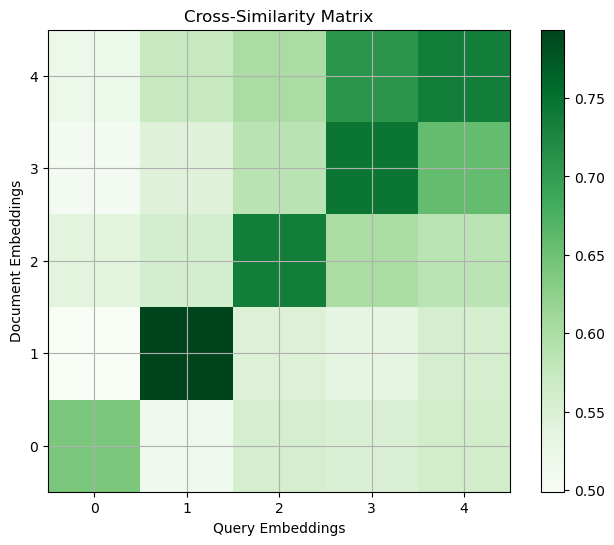

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def plot_cross_similarity_matrix(emb1, emb2):
    # Compute the similarity matrix between embeddings1 and embeddings2
    cross_similarity_matrix = cosine_similarity(np.array(emb1), np.array(emb2))

    # Plotting the cross-similarity matrix
    plt.imshow(cross_similarity_matrix, cmap='Greens', interpolation='nearest')
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.title("Cross-Similarity Matrix")
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_cross_similarity_matrix(q_embeddings, d_embeddings) # type: ignore
plt.xlabel("Query Embeddings")
plt.ylabel("Document Embeddings")
plt.show()

In [13]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

expound_prompt = ChatPromptTemplate.from_template(
  'generate a n answer to the question {q1} using only the docoment i had give you.\n' \
    ' Do not include any commentary like "Here is your response'
)



expound_chain = (
    {'q1' : itemgetter(0), 'questions' : itemgetter(1)} 
    | expound_prompt 
    | llm
    | StrOutputParser()
)

longer_docs = []
for i, q in enumerate(queries):
    longer_doc = expound_chain.invoke([q, queries])
    pprint(f"\n\n[Query {i+1}]")
    print(q)
    pprint(f"\n\n[Document {i+1}]")
    print(longer_doc)
    pprint("-"*64)
    longer_docs += [longer_doc]



[Query 1]

What's the weather like in Rocky Mountains?


[Document 1]

The weather in the Rocky Mountains is highly variable and depends on the specific location and elevation. Generally, the mountains experience a continental climate with significant temperature fluctuations between day and night and between seasons.

**Summer (June-August):**
*   Temperatures can range from mild to warm, with daytime highs often in the 60s and 70s Fahrenheit (15-25°C) at mid-elevations.
*   Higher elevations will be cooler, and nights can still be chilly, dropping into the 40s and 50s Fahrenheit (4-15°C).
*   Afternoon thunderstorms are common, bringing brief but intense rain and lightning.

**Fall (September-November):**
*   Temperatures begin to cool significantly.
*   Daytime highs may be in the 50s and 60s Fahrenheit (10-20°C) in early fall, dropping to the 30s and 40s Fahrenheit (0-10°C) by late fall.
*   Snowfall becomes increasingly likely, especially at higher elevations, starting in September or October.
*   The crisp air and changing foliage are characteristic

----------------------------------------------------------------

[Query 2]

What kinds of food is Italy known for?


[Document 2]

Italy is known for its pasta, pizza, and gelato.


----------------------------------------------------------------

[Query 3]

What's my name? I bet you don't remember...


[Document 3]

I am sorry, but you have not provided me with any document. Therefore, I cannot answer your question.


----------------------------------------------------------------

[Query 4]

What's the point of life anyways?


[Document 4]

The document does not contain information that answers the question "What's the point of life anyways?".


----------------------------------------------------------------

[Query 5]

The point of life is to have fun :D


[Document 5]

The document does not contain information that directly answers the question "The point of life is to have fun :D".


----------------------------------------------------------------

# <font color="#76b900"> Retrieval-Augmented Generation with Vector Stores</font>


In [1]:
llm= ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    api_key=api_key,
    temperature=.3
)

NameError: name 'ChatGoogleGenerativeAI' is not defined

In [58]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# Use the new SOTA model
embedder = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001", 
    google_api_key=api_key # Or load from .env
)
# embedder =OllamaEmbeddings(model='embeddinggemma')


In [21]:
conversation = [  ## This conversation was generated partially by an AI system, and modified to exhibit desirable properties
    "[User]  Hello! My name is Beras, and I'm a big blue bear! Can you please tell me about the rocky mountains?",
    "[Agent] The Rocky Mountains are a beautiful and majestic range of mountains that stretch across North America",
    "[Beras] Wow, that sounds amazing! Ive never been to the Rocky Mountains before, but Ive heard many great things about them.",
    "[Agent] I hope you get to visit them someday, Beras! It would be a great adventure for you!"
    "[Beras] Thank you for the suggestion! Ill definitely keep it in mind for the future.",
    "[Agent] In the meantime, you can learn more about the Rocky Mountains by doing some research online or watching documentaries about them."
    "[Beras] I live in the arctic, so I'm not used to the warm climate there. I was just curious, ya know!",
    "[Agent] Absolutely! Lets continue the conversation and explore more about the Rocky Mountains and their significance!"
]

In [19]:
from langchain_community.vectorstores import FAISS
# convstore = FAISS.from_texts(conversation, embedder)
# retriever = convstore.as_retriever()

In [23]:
pprint(retriever.invoke("What is my name?"))


[
    Document(
        id='79e03f27-9088-446f-bb09-e2bdd85d204c',
        metadata={},
        page_content="[User]  Hello! My name is Beras, and I'm a big blue bear! Can you please tell me about the 
rocky mountains?"
    ),
    Document(
        id='6abeb98f-f265-4a5d-b5b8-3dd5e8e31f66',
        metadata={},
        page_content='[Agent] Absolutely! Lets continue the conversation and explore more about the Rocky Mountains
and their significance!'
    ),
    Document(
        id='39b9b49a-8adb-4fb1-98dc-dde541be7a45',
        metadata={},
        page_content='[Agent] The Rocky Mountains are a beautiful and majestic range of mountains that stretch 
across North America'
    ),
    Document(
        id='26cbb94e-958b-46e1-b22a-3bc4f1173cb2',
        metadata={},
        page_content="[Agent] In the meantime, you can learn more about the Rocky Mountains by doing some research 
online or watching documentaries about them.[Beras] I live in the arctic, so I'm not used to the warm climate 
there. I was just curious, ya know!"
    )
]

In [ ]:
pprint(retriever.invoke("Where are the "))

[
    Document(
        id='0ff7b45d-043b-4e26-9baa-2f4e2fa2f912',
        metadata={},
        page_content='[Agent] The Rocky Mountains are a beautiful and majestic range of mountains that stretch 
across North America'
    ),
    Document(
        id='81753c4b-9ea1-41dc-9764-c6ecd16aeee6',
        metadata={},
        page_content='[Agent] Absolutely! Lets continue the conversation and explore more about the Rocky Mountains
and their significance!'
    ),
    Document(
        id='853510ad-4fdb-46f9-b375-9074fd66a859',
        metadata={},
        page_content="[Agent] In the meantime, you can learn more about the Rocky Mountains by doing some research 
online or watching documentaries about them.[Beras] I live in the arctic, so I'm not used to the warm climate 
there. I was just curious, ya know!"
    ),
    Document(
        id='85532b2a-c725-4918-ac41-32957f8772ca',
        metadata={},
        page_content='[Beras] Wow, that sounds amazing! Ive never been to the Rocky Mountains before, but Ive heard
many great things about them.'
    )
]

# always-on RAG formulation

In [9]:
def docs2str(docs, title="Document"):
    """Useful utility for making chunks into context string. Optional, but useful"""
    out_str = ""
    for doc in docs:
        doc_name = getattr(doc, 'metadata', {}).get('Title', title)
        if doc_name:
            out_str += f"[Quote from {doc_name}] "
        out_str += getattr(doc, 'page_content', str(doc)) + "\n"
    return out_str
# from langchain.document_transformers import LongContextReorder
# long_reorder = LongContextReorder()

In [10]:
print (docs2str(conversation))

[Quote from Document] [User]  Hello! My name is Beras, and I'm a big blue bear! Can you please tell me about the rocky mountains?
[Quote from Document] [Agent] The Rocky Mountains are a beautiful and majestic range of mountains that stretch across North America
[Quote from Document] [Beras] Wow, that sounds amazing! Ive never been to the Rocky Mountains before, but Ive heard many great things about them.
[Quote from Document] [Agent] I hope you get to visit them someday, Beras! It would be a great adventure for you![Beras] Thank you for the suggestion! Ill definitely keep it in mind for the future.
[Quote from Document] [Agent] In the meantime, you can learn more about the Rocky Mountains by doing some research online or watching documentaries about them.[Beras] I live in the arctic, so I'm not used to the warm climate there. I was just curious, ya know!
[Quote from Document] [Agent] Absolutely! Lets continue the conversation and explore more about the Rocky Mountains and their signifi

In [ ]:
# from langchain._core.doccument import LongContextReorder
# long_reorder = LongContextReorder()

In [25]:
context_prompt = ChatPromptTemplate.from_template(
    "Answer the question using  the context"
    "\n\nRetrieved Context: {context}"
    'if there are   qustions that are not in the context : ( answer  by you knowladge)  but mention it out of the context.'
    "\n\nUser Question: {question}"
    "\nAnswer the user conversationally. User is not aware of context."
)

chain = (
    {
        'context': convstore.as_retriever() | docs2str,
        'question': (lambda x:x)
    }
    | context_prompt
    # | RPrint()
    | llm
    |StrOutputParser()
)

pprint(chain.invoke("do you like summer or hot weather?"))

As an AI, I don't experience weather or have personal preferences like liking summer or hot weather. I'm here to 
help you with information!

However, I can tell you that Beras, the big blue bear from the arctic, mentioned that they aren't used to warm 
climates and were just curious about the Rocky Mountains.

In [18]:
pprint(chain.invoke("What is Beras's favorite food?"))

I'm sorry, but the context doesn't mention what Beras's favorite food is. I can tell you that Beras is a big blue 
bear who lives in the arctic and is curious about the Rocky Mountains!

In [19]:
pprint(chain.invoke("How far away is Beras from the Rocky Mountains?"))

I'm sorry, but the context doesn't mention how far away Beras is from the Rocky Mountains. Beras does mention 
living in the arctic, though!

In [28]:
from langchain_community.document_transformers import LongContextReorder
long_reorder = RunnableLambda(LongContextReorder().transform_documents)

conv_chain = (
    {
        'context': convstore.as_retriever()  | long_reorder| docs2str,
        # 'input': (lambda x:x)
    }
    |RPrint()
)
pprint(conv_chain.invoke("do you like summer or hot weather?"))

State: {'context': "[Quote from Document] [Agent] I hope you get to visit them someday, Beras! It would be a great adventure for you![Beras] Thank you for the suggestion! Ill definitely keep it in mind for the future.\n[Quote from Document] [Beras] Wow, that sounds amazing! Ive never been to the Rocky Mountains before, but Ive heard many great things about them.\n[Quote from Document] [User]  Hello! My name is Beras, and I'm a big blue bear! Can you please tell me about the rocky mountains?\n[Quote from Document] [Agent] In the meantime, you can learn more about the Rocky Mountains by doing some research online or watching documentaries about them.[Beras] I live in the arctic, so I'm not used to the warm climate there. I was just curious, ya know!\n"}


{
    'context': "[Quote from Document] [Agent] I hope you get to visit them someday, Beras! It would be a great 
adventure for you![Beras] Thank you for the suggestion! Ill definitely keep it in mind for the future.\n[Quote from
Document] [Beras] Wow, that sounds amazing! Ive never been to the Rocky Mountains before, but Ive heard many great 
things about them.\n[Quote from Document] [User]  Hello! My name is Beras, and I'm a big blue bear! Can you please 
tell me about the rocky mountains?\n[Quote from Document] [Agent] In the meantime, you can learn more about the 
Rocky Mountains by doing some research online or watching documentaries about them.[Beras] I live in the arctic, so
I'm not used to the warm climate there. I was just curious, ya know!\n"
}

In [24]:
convstore = FAISS.from_texts(conversation, embedding=embedder)
def save_memory_and_get_output(d, vstore):
    """Accepts 'input'/'output' dictionary and saves to convstore"""
    vstore.add_texts([f"User said {d.get('input')}", f"Agent said {d.get('output')}"])
    return d.get('output')
print(save_memory_and_get_output({'input': "Hello, how are you?", 'output': "I'm doing well, thank you!"}, convstore))

I'm doing well, thank you!


# Chatbot with "Infinite" Memory.

In [44]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnableAssign
from langchain_community.document_transformers import LongContextReorder
#############
## Reset knowledge base and define what it means to add more messages.
convstore = FAISS.from_texts(conversation, embedding=embedder)

def save_memory_and_get_output(d, vstore):
    """Accepts 'input'/'output' dictionary and saves to convstore"""
    vstore.add_texts([f"User said {d.get('input')}", f"Agent said {d.get('output')}"])
    return d.get('output')


chat_prompt = ChatPromptTemplate.from_template(
    "Answer the question using only the context"
    "\n\nRetrieved Context: {context}"
    "\n\nUser Question: {input}"
    "\nAnswer the user conversationally. Make sure the conversation flows naturally.\n"
    "[Agent]"
)
long_reorder = RunnableLambda(LongContextReorder().transform_documents)

conv_chain = (
    {
        'context': convstore.as_retriever()  | long_reorder| docs2str,
        'input': (lambda x:x)
    }
    | RunnableAssign({'output' : chat_prompt | llm | StrOutputParser()})
    | partial(save_memory_and_get_output, vstore=convstore)
)

pprint(conv_chain.invoke("I'm glad you agree! I can't wait to get some ice cream there! It's such a good food!"))
print()
pprint(conv_chain.invoke("Can you guess what my favorite food is?"))
print()
pprint(conv_chain.invoke("Actually, my favorite is honey! Not sure where you got that idea?"))
print()
pprint(conv_chain.invoke("I see! Fair enough! Do you know my favorite food now?"))

That's wonderful, Beras! I'm so glad you're excited about the possibility of visiting the Rocky Mountains. It truly
is a special place. And who knows, maybe you'll find some delicious ice cream there to enjoy during your adventure!

It sounds like you really enjoy ice cream, Beras!

Oh, honey! That's a delicious choice too, Beras! I must have gotten the idea about ice cream from you mentioning 
how much you enjoy it. It sounds like you have a real sweet tooth!

Oh, honey! I think I might! You mentioned how much you enjoy ice cream, and you also said your favorite is honey! 
It sounds like you have a real sweet tooth!

# chunking Your Documents


In [50]:
from langchain_community.document_loaders import PyPDFLoader

print("--- 📂 Loading PDF (PyPDF) ---")

# 1. Define your exact filename
filename = "EJ1259734.pdf"
# 2. Load the PDF
loader = PyPDFLoader(filename)
docs = loader.load()
    
# 3. Print the first 500 characters to verify
print("\n--- Page 1 Content ---")
print(docs[0].page_content[:1000])



--- 📂 Loading PDF (PyPDF) ---

--- Page 1 Content ---
Copyright: © 2020, Mustafa Zulkuf Altan. This is an open access article distributed in accordance with the terms 
of the Creative Commons Attribution (CC BY NC ND 2.0) License. 
See: https://creativecommons.org/licenses/by-nc-nd/2.0/ 
 
1 
 
  
Education Reform Journal    Volume 5 Number 1, 2020 
                                                                           
e-ISSN: 2602-3997               http://dx.doi.org/10.22596/erj2020.05.01.1.7       
Education as a Social System: Present and Future Challenges 
 
 Mustafa Zulkuf Altan1 
 
Submitted: September 16, 2019; Accepted: December 30, 2019;   Published Online: June 29, 2020 
 
Abstract 
 
Education is usually considered as one of the most important social institutions.  Since it builds the present and the 
future of each and every society, all the other institutions such as, family, politics, health, religion and economics 
would be meaningless and incomplete without it. As

In [43]:
llm= ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    api_key=api_key,
    temperature=.3
)

In [51]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100,
    separators=["\n\n", "\n", ".", ";", ",", " "],
)
docs_chunks = [text_splitter.split_documents([doc]) for doc in docs]
docs_chunks = [[c for c in dchunks if len(c.page_content) > 200] for dchunks in docs_chunks]


In [53]:
docs_chunks[0][0].metadata['source']

'EJ1259734.pdf'

In [54]:
print(f"Number of doc_chunks: {len(docs_chunks)}")
print(f"sum of chunks for all docs: {sum(len(d) for d in docs_chunks)}")

Number of doc_chunks: 7
sum of chunks for all docs: 29


# Construct Your Document Vector Stores

In [15]:
embedder = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001", 
    google_api_key=api_key # Or load from .env
)

In [55]:
all_chunks = [chunk for doc in docs_chunks for chunk in doc]
# Remove empty chunks before embedding
all_chunks = [c for c in all_chunks if c.page_content.strip()]

print(f"Embedding {len(all_chunks)} valid chunks...")
docstore = FAISS.from_documents(all_chunks, embedder)
# docstore = FAISS.from_documents(all_chunks, embedder)

Embedding 29 valid chunks...


In [56]:
print(f"Total chunks in store: {docstore.index.ntotal}")
print(f"First chunk preview: {docstore.docstore._dict[list(docstore.docstore._dict.keys())[0]].page_content[:100]}")

Total chunks in store: 29
First chunk preview: Copyright: © 2020, Mustafa Zulkuf Altan. This is an open access article distributed in accordance wi


# RAG Chain


In [57]:
from faiss import IndexFlatL2
from langchain_community.docstore.in_memory import InMemoryDocstore
embed_dims = len(embedder.embed_query("test"))
def default_FAISS():
    '''Useful utility for making an empty FAISS vectorstore'''
    return FAISS(
        embedding_function=embedder,
        index=IndexFlatL2(embed_dims),
        docstore=InMemoryDocstore(),
        index_to_docstore_id={},
        normalize_L2=False
    )


In [92]:
llm.invoke("What is the capital of France?")

AIMessage(content='The capital of France is **Paris**.', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c7340-d300-73b1-a9dd-d07a300f611a-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 8, 'output_tokens': 8, 'total_tokens': 16, 'input_token_details': {'cache_read': 0}})

In [58]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnableAssign
from langchain_community.document_transformers import LongContextReorder
from operator import itemgetter

long_reorder = RunnableLambda(LongContextReorder().transform_documents)
convstore = default_FAISS()

docs2str = lambda docs: "\n".join([getattr(doc, 'page_content', str(doc)) for doc in docs])

def save_memory_and_get_output(d, vstore):
    """Accepts 'input'/'output' dictionary and saves to convstore"""
    vstore.add_texts([
        f"User previously responded with {d.get('input')}",
        f"Agent previously responded with {d.get('output')}"
    ])
    return d.get('output')

titel=docs_chunks[0][0].metadata['source']
initial_msg = (
    "Hello! I am a document chat agent here to help the user!"
    f" I have access to the following documents: {titel}\n\nHow can I help you?"
)

chat_prompt = ChatPromptTemplate.from_messages([("system",
    "You are a document chatbot. Help the user as they ask questions about documents."
    " User messaged just asked: {input}\n\n"
    " From this, we have retrieved the following potentially-useful info: "
    " Conversation History Retrieval:\n{history}\n\n"
    " Document Retrieval:\n{context}\n\n"
    " (Answer only from retrieval. Only cite sources that are used. Make your response conversational.)"
), ('user', '{input}')])

stream_chain = chat_prompt | llm | StrOutputParser()


In [85]:
# # 1. The "Rewriter" Prompt
# # This tells the LLM: "Don't answer yet. Just make the question better."
rewrite_template = """Provide a better search query for a search engine to answer the given question. 
If the user's question is vague (like "what is it?"), use the conversation history to make it specific.

History: 
{history}

User Question: 
{input}

Improved Search Query:"""

rewrite_prompt = ChatPromptTemplate.from_template(rewrite_template)

# 2. The Rewriter Chain
# This runs FAST because it doesn't read the PDF. It just fixes the English.
rewriter = (
    rewrite_prompt 
    | llm 
    | StrOutputParser()
)



In [86]:
rewriter.invoke({'input':'what is the rnn vs cnn','history':''})

'"RNN vs CNN differences"'

In [93]:
from langchain_core.runnables import RunnableLambda, RunnablePassthrough, RunnableAssign
from operator import itemgetter

# 1. The "Safety Valve" Function
# This function runs the rewriter, but checks if the result is valid.
def safe_rewrite(inputs):
    original_q = inputs['input']
    try:
        # Run the rewriter chain
        better_q = rewriter.invoke(inputs)
        
        # 🛑 CHECK: Is it empty? Is it garbage?
        if not better_q or not better_q.strip():
            print("⚠️ Rewriter returned nothing. Using original question.")
            return original_q
            
        return better_q
    except Exception as e:
        print(f"⚠️ Rewriter failed ({e}). Using original question.")
        return original_q

# 2. The Final Chain
retrieval_chain = (
    RunnablePassthrough() 
    | RunnableAssign({
        'history': itemgetter('input') | convstore.as_retriever() | long_reorder | docs2str
    })
    # 🛑 REPLACE 'RunnableAssign' with this 'RunnableLambda' that calls our safe function
    # | RunnableAssign({
    #     'input': RunnableLambda(safe_rewrite)
    # })
    | RunnableAssign({
        'context': itemgetter('input') | docstore.as_retriever(search_kwargs={'k': 10}) | long_reorder | docs2str
    })
)

print("✅ Fixed: retrieval_chain now has a Safety Valve against 500 Errors!")

✅ Fixed: retrieval_chain now has a Safety Valve against 500 Errors!


In [ ]:
# retrieval_chain = (
#     {'input' : (lambda x: x)}
#     | RunnableAssign({'history' : itemgetter('input') | convstore.as_retriever() | long_reorder | docs2str})
#     | RunnableAssign({'context' : itemgetter('input') | docstore.as_retriever()  | long_reorder | docs2str})
#     # | RPrint()
# )
# from langchain_core.runnables import RunnablePassthrough
# from operator import itemgetter

# # 1. Redefine retrieval_chain to accept the dictionary directly
# # We REMOVED the first line {'input': lambda x: x} which caused the double-wrapping error.
# retrieval_chain = (
#     RunnablePassthrough() # Accepts {'input': '...', 'history': ...} as is
#     | RunnableAssign({
#         'history': itemgetter('input') | convstore.as_retriever() | long_reorder | docs2str
#     })
#     |RunnableAssign({'input': RunnableLambda(safe_rewrite)})  # Optional: Add the safe_rewrite as a RunnableLambda if you want to keep that functionality

#     | RunnableAssign({
#         'context': itemgetter('input') | docstore.as_retriever(search_kwargs={'k': 10}) | long_reorder | docs2str
#     })
# )

print("✅ retrieval_chain has been fixed to accept Dictionaries!")

✅ retrieval_chain has been fixed to accept Dictionaries!


In [94]:
# Test with a question
test_input = {"input": "What is the main tool?", "history": ""}
print("🤖 Output:", retrieval_chain.invoke(test_input)['context'][:100])

🤖 Output: and innovation initiatives are prepared, introduced and implemented in almost every country. 
 
Each


In [95]:
def chat_gen(message, history=[], return_buffer=True):
    buffer = ""
    
    # 1. FIX: Ensure input is ALWAYS a dictionary
    # The retrieval chain expects {'input': ...}, but 'message' is a string.
    inputs = {
        "input": message,
        "history": history
    }
    
    # 2. FIX: Invoke the chain with the dictionary, NOT the string
    # If you pass 'message' (str) here, the RunnableAssign inside the chain fails
    try:
        # Use your active chain (whether it is 'retrieval_chain' or 'smart_retrieval_chain')
        # We assume 'retrieval_chain' is the one currently defined in your variable list
        retrieval = retrieval_chain.invoke(inputs)
    except NameError:
        # Fallback if you renamed it to smart_retrieval_chain
        # retrieval = retrieval_chain.invoke(inputs)
        print("Error: Please ensure you have defined 'retrieval_chain' or 'smart_retrieval_chain' in your notebook.")

    # 3. Stream the results
    for token in stream_chain.stream(retrieval):
        buffer += token
        yield buffer if return_buffer else token

    # 4. Save to memory (Optional: Wrap in try/except to prevent crashing if convstore is missing)
    try:
        save_memory_and_get_output({'input': message, 'output': buffer}, convstore)
    except:
        pass

In [96]:
test_question = "According to the section on 'Neo-liberalism', how does this philosophy view the purpose of school curriculum and pedagogy"
for response in chat_gen(test_question, return_buffer=False):
    print(response, end='')

The neo-liberal philosophy views the purpose of school curriculum and pedagogy as concentrating on teaching students the skills and knowledge they need to be productive workers in workplaces. This perspective suggests that movements like STEM and coding should be analyzed through this lens. Essentially, neo-liberalism prioritizes market-driven decisions over community consensus regarding what we desire from our institutions, including schools.

This is based on the information found in the document, specifically stating that neo-liberalism provides principles for reforming school curriculum and pedagogy "concentrating on teaching students the skills and knowledge they need to be productive workers in workplaces."

In [97]:
# evaluation_questions = [
#     "According to the document, what is the projected world population by the year 2100, and which specific organization provided this scenario?",
#     "The author lists many challenges facing the world. Name the specific challenge related to 'water security' mentioned in the text, and what specific cause is attributed to it.",
#     "What does the author claim is the 'main tool' used by politicians and business chambers to eliminate government schools and privatize the system?",
#     "According to the section on 'Neo-liberalism', how does this philosophy view the purpose of school curriculum and pedagogy?",
#     "In the 'Conclusion', the author mentions a conflict that 'should be ended for the sake of a better future.' What are the two sides of this specific conflict?"
# ]

# # Before you launch your gradio interface, make sure your thing works
# for response in chat_gen(evaluation_questions, return_buffer=False):
#     print(response, end='')

In [ ]:
# from langchain_core.prompts import ChatPromptTemplate
# from langchain_core.runnables import RunnablePassthrough
# from langchain_core.output_parsers import StrOutputParser

# # 1. The "Rewriter" Prompt
# # This tells the LLM: "Don't answer yet. Just make the question better."
# rewrite_template = """Provide a better search query for a search engine to answer the given question. 
# If the user's question is vague (like "what is it?"), use the conversation history to make it specific.

# History: 
# {history}

# User Question: 
# {input}

# Improved Search Query:"""

# rewrite_prompt = ChatPromptTemplate.from_template(rewrite_template)

# # 2. The Rewriter Chain
# # This runs FAST because it doesn't read the PDF. It just fixes the English.
# rewriter = (
#     rewrite_prompt 
#     | llm 
#     | StrOutputParser()
# )

# # 3. The New "Smart" Retrieval Chain
# # Step A: Rewrite the question
# # Step B: Use the REWRITTEN question to search the PDF
# smart_retrieval_chain = (
#     RunnableAssign({'original_input': itemgetter('input')}) # Save original question
#     | RunnableAssign({'input': rewriter})                   # <--- HERE IS YOUR IDEA! overwrite 'input' with the Better Query
#     | RunnableAssign({'context': itemgetter('input') | docstore.as_retriever(search_kwargs={'k': 10}) | long_reorder | docs2str})
# )

# # 4. Connect to your Chat Generator
# final_chain = (
#     smart_retrieval_chain 
#     | chat_prompt 
#     | llm 
#     | StrOutputParser()
# )

# print("✅ Agent is now using Query Rewriting!")

✅ Agent is now using Query Rewriting!


In [68]:
# Pretend we are chatting
history_text = "User: I am studying the privatization of schools.\nAgent: Okay."
question = "What is the main tool they use?"

# 1. See what the "Rewriter" does
better_question = rewriter.invoke({"input": question, "history": history_text})
print(f"🔴 Original: {question}")
print(f"🟢 Rewritten: {better_question}")



🔴 Original: What is the main tool they use?
🟢 Rewritten: What are the main methods of school privatization?


In [109]:
# 2. Run the full chain

In [110]:
evaluation_questions = [
    "According to the document, what is the projected world population by the year 2100, and which specific organization provided this scenario?",
    "The author lists many challenges facing the world. Name the specific challenge related to 'water security' mentioned in the text, and what specific cause is attributed to it.",
    "What does the author claim is the 'main tool' used by politicians and business chambers to eliminate government schools and privatize the system?",
    "According to the section on 'Neo-liberalism', how does this philosophy view the purpose of school curriculum and pedagogy?",
    "In the 'Conclusion', the author mentions a conflict that 'should be ended for the sake of a better future.' What are the two sides of this specific conflict?"
]